## Goal
Analize the effect of price changes on product sales in order to maximize revenue.  Answer the question how 
sensitive is the consumer to price changes.


Introduction
1) Exploratory Data Analysis
2) Elasticity definition
3) Calculating the effect of price changes on sales using linear regression

Which will allow us to answer these questions: 

4) How do consumers respond to price increases? What other factors affect consumers? (Confounders, outliers, residuals) 
5) What is the effect across the different prices (example $12 versus $15)  (Non-linearity) 
6) Is the effect of price increases affected by other variables? For example, are consumers more sensitive to price increases during the weekend? (Interaction terms, familywise error rates) 
7) Are they becoming more or less price sensitive over time?   ( Recursive OLS)

More advanced topics

8) How can we account for factors that we cannot measure? For example, what the effect of advertisement? (Mixture models, unobserved heterogeneity)

Appendix (Unfinished)

Due to time constraints, this notebook highlgihts some statistical techniques, but it is not complete or thorough 

In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns
import os
from matplotlib import pyplot as plt

import statsmodels.graphics.regressionplots as rp
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
import statsmodels.api as sm
import math
from plotly_calplot import calplot
from plotly.offline import plot
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from statsmodels.regression.linear_model import RegressionResultsWrapper
from statsmodels.stats.outliers_influence import variance_inflation_factor

import scipy.optimize as opt
from scipy.stats import norm, poisson

pio.templates.default = "plotly_dark"
np.random.seed(42)
pd.set_option('display.float_format', '{:.2f}'.format)

import warnings
warnings.filterwarnings("ignore")

import LR as lr


In [ ]:
df = pd.read_csv('c:/data/cafe.csv', parse_dates=['CALENDAR_DATE'], index_col='CALENDAR_DATE') 
df2 = pd.read_csv('c:/data/cafe_tran.csv', parse_dates=['CALENDAR_DATE'], index_col='CALENDAR_DATE')

dft = pd.merge(df2, df, on='CALENDAR_DATE', how='inner')

dft = dft[dft['SELL_CATEGORY']==2]

## 1. Exploratory Data Analysis

Our data represents a few years of daily sales for different products along with price and quantity sold for that day

In [5]:
dft.head()

,PRICE,QUANTITY,SELL_ID,SELL_CATEGORY,YEAR,HOLIDAY,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
CALENDAR_DATE,,,,,,,,,,
2012-01-01,12.73,22,2051,2,2012,New Year,1,0,24.80,0
2012-01-01,12.75,18,2052,2,2012,New Year,1,0,24.80,0
2012-01-01,12.60,30,2053,2,2012,New Year,1,0,24.80,0
2012-01-02,12.73,22,2051,2,2012,New Year,0,0,24.80,0
2012-01-02,12.75,16,2052,2,2012,New Year,0,0,24.80,0


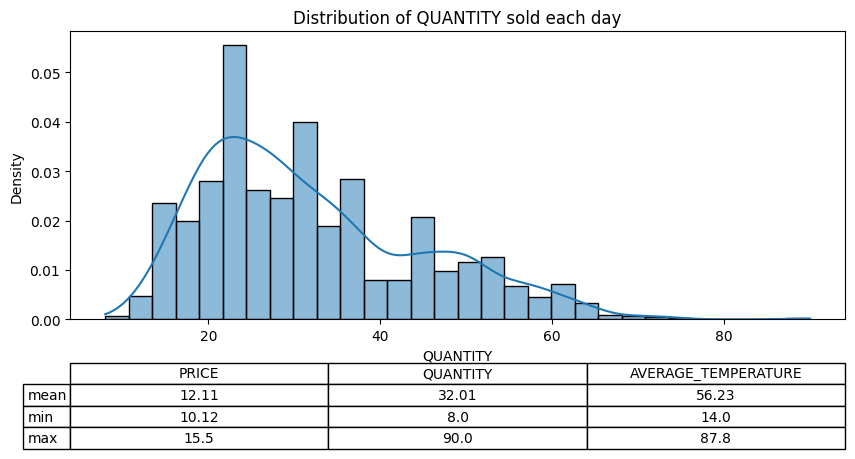

In [6]:

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=dft, x="QUANTITY", bins=30, kde=True, stat='density', ax=ax)

# Extract and round summary statistics
summary = dft.describe().loc[['mean','min', 'max'], ['PRICE', 'QUANTITY', 'AVERAGE_TEMPERATURE']]
summary_rounded = summary.round(2)

# Add the table below the plot
table = plt.table(cellText=summary_rounded.values,
                  rowLabels=summary_rounded.index,
                  colLabels=summary_rounded.columns,
                  cellLoc='center',
                  loc='bottom',
                  bbox=[0, -0.45, 1, 0.3])  # [left, bottom, width, height]

table.scale(1, 1.5)  # Resize the table

# Adjust the layout to prevent overlap
plt.subplots_adjust(bottom=0.4)

# Title and labels
ax.set_title('Distribution of QUANTITY sold each day')
ax.set_xlabel('QUANTITY')
ax.set_ylabel('Density')

plt.show()


In the 3 year sample period we have an average price of $12 with average sales of 32K per day. The price has ranged from $10 to $15 in these 3 years as shown below sometimes changing daily within the same period

In [7]:
fig2 = px.scatter(dft, x=dft.index, y="PRICE", title="Average price in the last 3 years" )

fig2.update_layout(width=800, height=600)
fig2.show()

## 2. Elasticity definition

Too long to read TL;DR

Key takeaways: \
Elasticity = price sensitivity = Price coefficient in linear regression.\
Revenue is maximized when elasticity = 1




Price elasticity can be used to measure consumer price sensitivity.  

Price Elasticity of Demand measures how sensitive the quantity demanded (by consumers) of a good or service is to changes in price. The formula is given by:

E = Change in quanitty divided by change in price

In this example below we can see how quantity sold changes when price is decreaseed by $1 from $8 to $7 with its respective change in sales increasing from 110K to 130K, thus increasing overall sales from 110K to 130K, which more than offsets the decrease in price

E = 1.2 is our elasticity of demand as calculated below

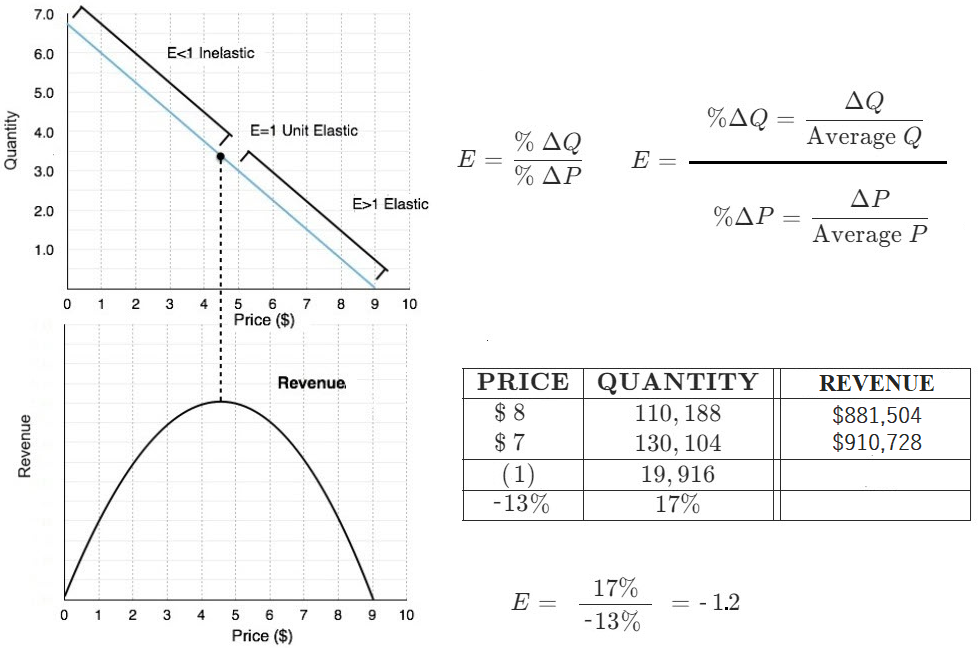

Since consumers are sensitive to price, we expect elasticity of demand (ED) to be negative meaning an inverse relation between price and demand (An increase in price, reduces demand).  Oftentime, this negative relationship is taken for granted and ED is shown as positive for ease of reading, but is understood to be negative.

In our example, at price point of $8 there is an elasticity of 1.2, which indicates that demand is elastic, and responds more than proportionally to changes in price.  In other words, quantity demanded increases/decreases greater than the corresponding percent change in price.  To maximize revenue, we should reduce price from $8 to $4.5 ( line dots on the graph above) because the drop in price is more than offset with an increase in demand, thus leading to higher revenue.  After $4.5 the increase in demand is not enough to offset the decline in price, thus revenue starts to decline

**This implies that our revenue maximizing price is the price where elasticity = 1**

The rules follow the summary below:

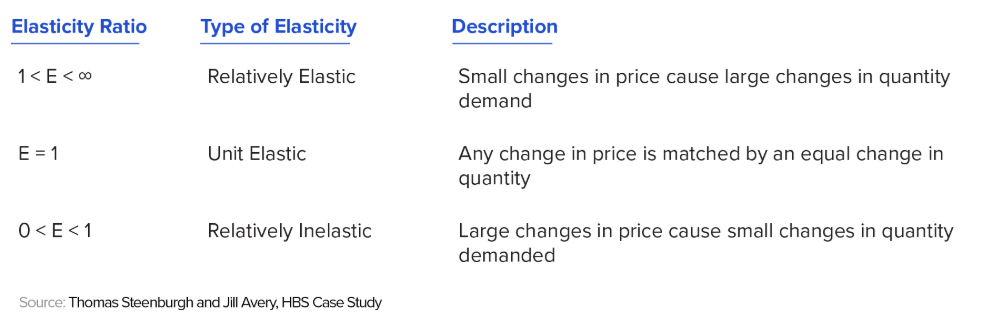



Another way to calculate elasticity is by using linear regression as shown below.  Doing so allows us to incorporate other factors into the demand equation

## 3. Calculating elasticity for our data

To use linear regression to calcualte price elasticity, we take a log of price and quantity. This converts our linear regression from an additive model, to a multiplicative one where a 1% increase in X results in a proportional 1% increase in Y

$$
log(y) = \beta_0 + \beta_1 log(x) + \varepsilon
$$

Where: 
- $\beta_0$ is the intercept
- $\beta_1$ is the effect of price on quantity (elasticity)
- $\varepsilon$ is the error


Our simple regression model shows a price coefficient of 1.29, which is the price elasticity of demand.  The intercept represents what the demand would be if price were equal to zero (In our example, its uninformative since price will never be zero, and a price of zero is outside the range of samples)

In [8]:
model1 = smf.ols(formula='np.log(QUANTITY) ~ np.log(PRICE)', data=dft).fit()
print(model1.summary().tables[1])

                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.6226      0.208     31.842      0.000       6.215       7.030
np.log(PRICE)    -1.2988      0.083    -15.565      0.000      -1.462      -1.135


## 4. Which factors should we include in our model?
Confounders

When we plot the results of our regression in a scatterplot for price and quantity, we see the general inverse relation as expected with higher  prices leading to lower quantities, but we have some data points that seem to break the rule.  For example, at a price of $15 (highlighted in red), demand is HIGHER than at a price of $10 which implies that a couple of days consumers were willing to buy more at $15 than they did when the price was $10.

See graph below

This could have happened because it was a special day of the year, which skewed demand higher irrespective of the higher price. This example, shows the need to account for other factors other than price (known as confounders) to truly be able to capture the effects of price changes in quantities sold.



In [9]:
highlight = dft[dft['PRICE'] == 15.50]

fig = px.scatter(dft, x='PRICE', y='QUANTITY', opacity=0.7, title="Price vs Quantity")
fig.add_scatter(x=highlight['PRICE'], y=highlight['QUANTITY'], mode='markers',
                marker=dict(color='red', size=10), name='Outliers')


fig.update_layout(width=800, height=600)
fig.show()


For example, if we plot out demand by day of the week and month, we can see that weekdays and summer months tend to have higher demand.  Thus we need to include them as confounders.

In [10]:
adft = dft.copy()
adft['C_DATE'] = adft.index
fig = calplot(adft[adft.index.year==2012], x='C_DATE', y='QUANTITY'
              , dark_theme=True
              , title='Sales')
fig.show()

To include weekend as a variable, we'll set the variables as 0 for weekday, and 1 for weekend (often referred to as one-hot encoded)

$$
log(y) = \beta_0 + \beta_1 log(X_1) + \beta_2 X_2 + \varepsilon
$$

Where: 
- $\beta_0$ is the intercept
- $\beta_1$ is the price elasticity
- $\beta_2$ represents weekend
- $\varepsilon$ is the error



In [11]:
model2 = smf.ols(formula='np.log(QUANTITY) ~ np.log(PRICE) + IS_WEEKEND', data=dft).fit()
print(np.exp(model2.params[2]))
print(model2.summary().tables[1])

0.7309244497164543
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.7281      0.194     34.730      0.000       6.348       7.108
np.log(PRICE)    -1.3055      0.078    -16.799      0.000      -1.458      -1.153
IS_WEEKEND       -0.3134      0.013    -24.963      0.000      -0.338      -0.289




Including weekend in our model, we can see that demand is 27% lower (calculated as e^-.31 since we took the log or our data) during the weekend than on weekdays, and the variable is highly significant.  However, our estimated effect of price remained roughly equal.

Similarly, we could account for all other factors that could influence demand and affect our estimate of elasticity.  Adding temperature (as shown below) changed the effect/elasticity slightly to 1.36.

In [12]:
full_model = smf.ols(formula='np.log(QUANTITY) ~ np.log(PRICE) + IS_WEEKEND + np.log(AVERAGE_TEMPERATURE)', data=dft).fit()
print(full_model.summary().tables[1])


                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       7.1391      0.211     33.896      0.000       6.726       7.552
np.log(PRICE)                  -1.3630      0.078    -17.390      0.000      -1.517      -1.209
IS_WEEKEND                     -0.3131      0.013    -25.009      0.000      -0.338      -0.289
np.log(AVERAGE_TEMPERATURE)    -0.0677      0.014     -4.898      0.000      -0.095      -0.041


### Which factors should we include?

For our model to give us the correct effect it must (among a few other things):

1) Correct functional form - if using a linear model, the effect must be linear, or the model must include correct transformations/interactions
2) The effect must be additive (or multiplicative if proper transformation)
3) All relevant predictors must be included

How do we know which predictors/confounders to include? Why cant we include all of them?  The answer revolves around the bias/variance (overfit/underfit) tradeoff as best described in the picture below.  A biased estimate is one that consistently underestiamtes or overestimates, where an estimate with high variance is one that fluctuates a lot depending on the sample (more unpredictable)

If we are missing predictors, our estimates will be biased, but if we include too many predictors (both redundant predictors or uninformative ones), then we add to the variance.  

In other words, we cant leave out important predictors, but also cant include everything.



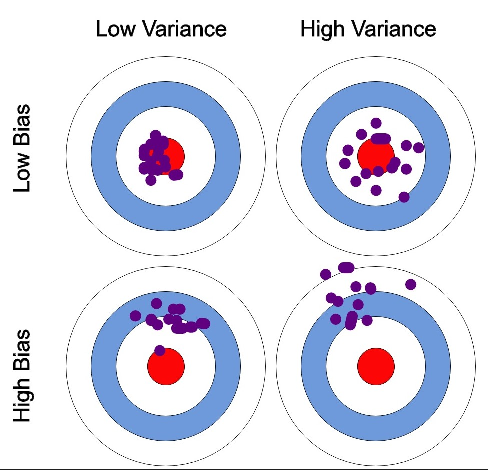

In [13]:
# Adding a highly correlated predcitor for illustration
dft['PRICE2'] = dft['PRICE'] * 0.8 + np.random.normal(0, .3, size=len(dft))  


#### Lets illustrate an example of what happens if we include redundant predictors

In the model we have seen so far (shown below), we had a 95% confidence interval for PRICE is from -1.58 to -1.21.  This means that if we were to take another sample, 95% of the time our effect would lie within this range.  See below

Note that the print out for the stats results now includes a column called VIF which stands for Variance Inflation Factor. This value indicates how inflated the variance in the model is given the correlation (redundancy) of the predictors.  A VIF = 1 indicates that variance is not inflated.

In [14]:
full_model = smf.ols(formula='np.log(QUANTITY) ~ np.log(PRICE) + IS_WEEKEND + np.log(AVERAGE_TEMPERATURE)', data=dft).fit()
full_model = lr.stats(full_model)
full_model.print_summary()

,coef,std err,t,P>|t|,[0.025,0.975],VIF
Intercept,7.14,0.21,33.90,0.00,6.73,7.55,1391.06
IS_WEEKEND,-0.31,0.01,-25.01,0.00,-0.34,-0.29,1.00
np.log(AVERAGE_TEMPERATURE),-0.07,0.01,-4.90,0.00,-0.10,-0.04,1.02
np.log(PRICE),-1.36,0.08,-17.39,0.00,-1.52,-1.21,1.02


In the next model, we include a redundant (highly correlated) predictor to PRICE, and we can see how the VIF jumped from 1 to 6 for PRICE.  Indicating that our variance is now 6 times higher than it should be if we eliminate the reduandancy.  The 95% CI jupmed from negative 1.58-1.27 in our prior model to negative 2.03-1.26. Our range of estimate for the effect of PRICE on amounts sold is now not so reliable.

In [15]:
redundant_model = smf.ols(formula='np.log(QUANTITY) ~ np.log(PRICE) + IS_WEEKEND + np.log(AVERAGE_TEMPERATURE) + np.log(PRICE2)', data=dft).fit()
redundant_model = lr.stats(redundant_model)
redundant_model.print_summary()


,coef,std err,t,P>|t|,[0.025,0.975],VIF
Intercept,7.18,0.21,33.48,0.00,6.76,7.60,1442.16
IS_WEEKEND,-0.31,0.01,-25.01,0.00,-0.34,-0.29,1.00
np.log(AVERAGE_TEMPERATURE),-0.07,0.01,-4.88,0.00,-0.10,-0.04,1.02
np.log(PRICE),-1.55,0.20,-7.84,0.00,-1.94,-1.16,6.51
np.log(PRICE2),0.19,0.18,1.03,0.30,-0.17,0.54,6.50


Below, we re-run the linear regression 100 times for each model and plot the obtained coefficient.  As you can see, the redundant model gives us quite a large range of coefficients.

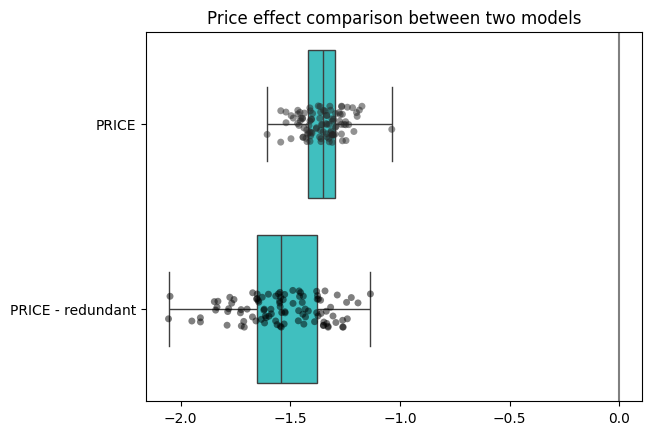

In [16]:
full_mod_bootstrap = full_model.bootstrap_coeff(False)
full_mod_bootstrap.rename(columns={'np.log(PRICE)': 'PRICE', 'IS_WEEKEND': 'WEEKEND', 'np.log(AVERAGE_TEMPERATURE)': 'TEMPERATURE'}, inplace=True)
redundant_mod_bootstrap = redundant_model.bootstrap_coeff(False)
redundant_mod_bootstrap.rename(columns={'np.log(PRICE)': 'PRICE - redundant', 'IS_WEEKEND': 'WEEKEND', 'np.log(AVERAGE_TEMPERATURE)': 'TEMPERATURE', 'np.log(PRICE2)': 'PRICE2'}, inplace=True)

d_for_g = pd.concat([full_mod_bootstrap['PRICE'], redundant_mod_bootstrap['PRICE - redundant']], axis=1)

sns.stripplot(data=d_for_g, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=d_for_g, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5") 
plt.title("Price effect comparison between two models")
plt.show()

Lastly, increased variance also has an effect on testing for significance (hypothesis testing):  If a feature is highly correlated with another feature in the model, it may appear insignificant when both are included, even if it's individually important.

### Outliers

Was adding temperature and weekend enough to explain our confounding data points at $15?  To answer that question, we'll check the residuals for outliers.  Residuals are simply the difference between the true target value, and the value our model estimated.  This will tell us what points our model is having trouble explaining, which could give us information about other predictors that need to be also included in the model (or about model misspecification)

We plot the residuals for all predictors and see what we find


In [17]:
# influence = full_model.get_influence()
# cooks_d = influence.cooks_distance[0]
# leverage = influence.hat_matrix_diag
# std_resid = influence.resid_studentized_internal
# fitted_values = np.exp(full_model.fittedvalues)

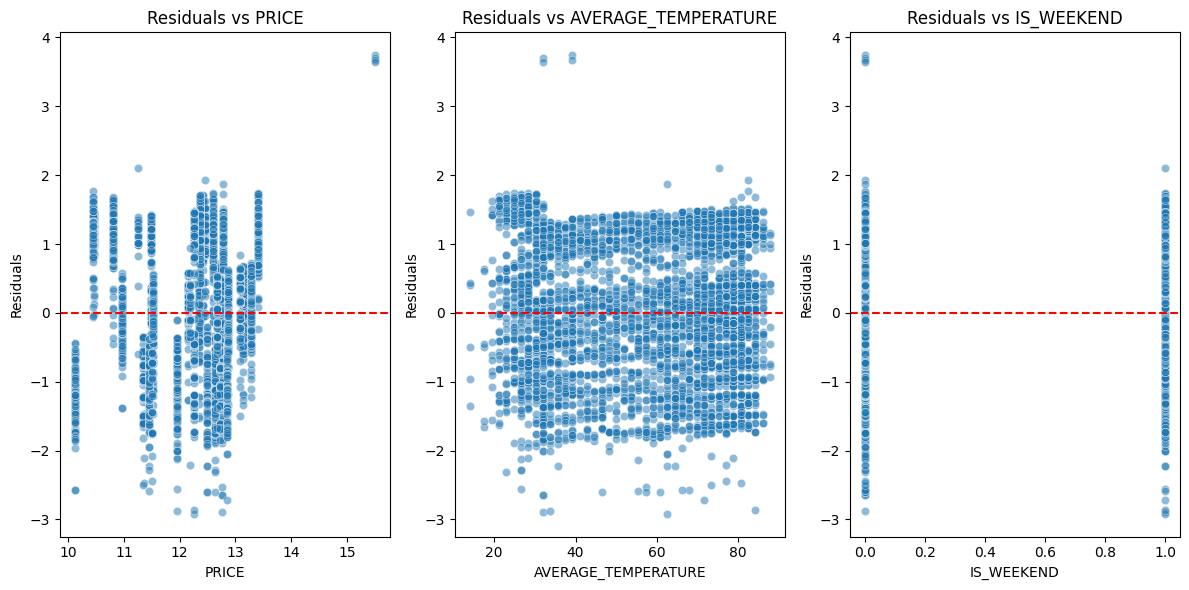

In [18]:

labels = ['PRICE', 'AVERAGE_TEMPERATURE', 'IS_WEEKEND']
full_model.plot_residuals_all(dft, labels)

We can see that our model still has trouble explaining why there was so much demand for our product at such a high prices.  The inclusion of weekend and temperature was not able to explain this outcome.  Perhaps those days were holidays and we have not included holidays as a predictor, but because these points happened on the weekend (they show up on the 0 axis of our weekend residual) this is less likely.

what should we do with them?


#### A closer look at outliers

To deal with the outliers, we can measure what is the effect of them on our model.  For a dataset to have an influence in our model, it must be both an outlier, but also have high leverage.

What is high leverage? Where an outlier is an unusual y (an unusual outcome), a high leverage is an unusual X. In our case an unusual price of $15, a price point that is not very common in opur dataset as it was represented only two days.

There are multiple measurements that can be used to quantify the effect of particular outliers in our model.  We'll start by looking a Cook's distance which quantifies this. Cook's distance is a measure of how much impact each point has in the model as a whole (how it affects all coefficients in the model) given its residuals, and leverage.   Points with larger Cook's (lighter color) have a greater impact.  The graph below shows the potential of each and every point in our results

In [19]:
dft2 = dft.reset_index()

# Create a DataFrame for the influence measures
influence_df = pd.DataFrame({
    'CALENDAR_DATE': dft2.CALENDAR_DATE,
    'PRICE': dft2.PRICE,
    'Leverage': full_model.leverage,
    'Cook\'s Distance': full_model.cooks_d,
    'Studentized Residuals': full_model.std_resid
})

# Create a scatter plot using Plotly
fig = px.scatter(influence_df, x='Leverage', y='Studentized Residuals',
                 color='Cook\'s Distance', hover_data= ['CALENDAR_DATE', 'PRICE'],
                 labels={'Leverage': 'Leverage', 'Standardized Residuals': 'Standardized Residuals'},
                 title="Influence Plot (Leverage vs Standardized Residuals)",
                 color_continuous_scale='Viridis')

# Add labels for Cook's Distance
fig.update_traces(marker=dict(size=12),
                  selector=dict(mode='markers'))
fig.show()


We can see that, the four days with $15.5 are still the most problematic (colored yellow) and perhaps the only points that could bias our estimated coefficient. These days not only have outliers, they also have high leverage.

Since in this case we are interested only in the effect of price (elasticity) (the coefficient for X1) we can use a measure specific to this coefficient called dfbetas.  dfbetas gives us the exact quantity each coefficient would change by if the questionable points were to be removed. 

For example, our 4 points with $15.5 if removed would affect our estimate by:


In [20]:
# print(full_model.summary().tables[1])
se_betas = full_model.bse 
get_idx = list(full_model.params.index).index('np.log(PRICE)')
total_beta_change = full_model.dfbetas[dft['PRICE']==15.5][:, get_idx].reshape(-1, 1) * se_betas[get_idx]
print("Effect of each point: ")
print(total_beta_change, '\n')
print("Total effect (Sum) on price elasticity of removing all four points", np.sum(total_beta_change))

Effect of each point: 
[[0.01549655]
 [0.01499894]
 [0.01523675]
 [0.0147449 ]] 

Total effect (Sum) on price elasticity of removing all four points 0.06047713877015503


Below  we can see the coefficient for price elasticity with the points removed.  Just as we had predicted, the effect changed by .06 or so. 

In [21]:
print("Price elasticity before: ", full_model.params['np.log(PRICE)'])
print("Price elasticity after removing outliers : ",
      smf.ols(formula='np.log(QUANTITY) ~ np.log(PRICE) + IS_WEEKEND + np.log(AVERAGE_TEMPERATURE)'
     , data=dft[~(dft['PRICE'] == 15.5)]).fit().params['np.log(PRICE)'])


Price elasticity before:  -1.3629855257824657
Price elasticity after removing outliers :  -1.4239675162774985


If we cannot find any variable to explain these datapoints, we have to make a decision of what to do with them.  In our case, we'll just drop them

In [22]:
dft = dft[~(dft['PRICE'] == 15.5)]

# 5. Are consumers equally sensitive to price changes across all prices ?

One of the problems with our models so far is that it estimates a constant effect across all price points (As shown on the (right) graph below (red line))  That would mean that consumers are equally sensitive to price changes regardless of price.  In other words, going from $10 to $12 has the same elasticity as going from $20 to $22, which is likely not the case.   


The graph on the left will show a scatterplot of price and sales, the one on the right will show the effect of changes in price to how much is sold. Recall from our section on elasticity that revenue is maximized when prodcuts are sold at an elasticity of 1

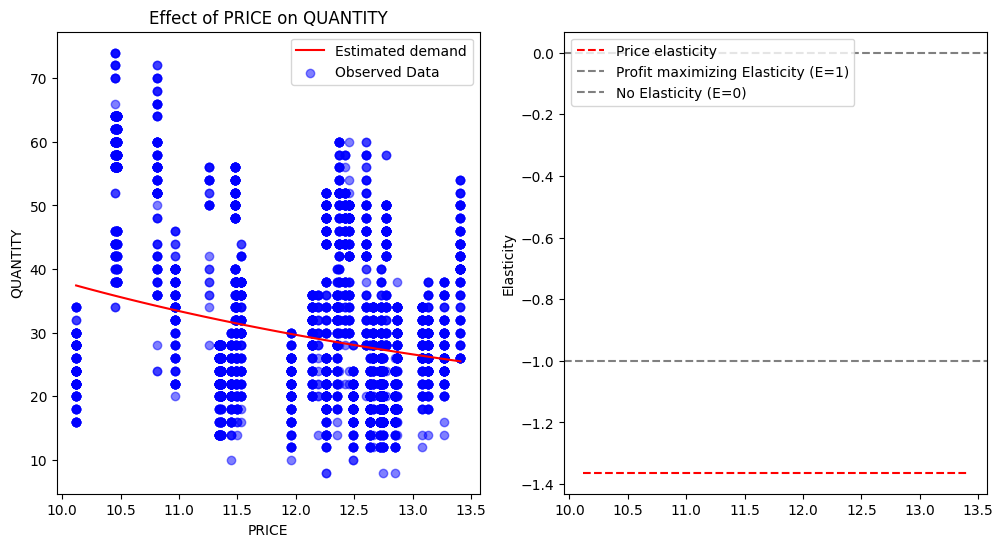

In [23]:
pmin = dft['PRICE'].min()
pmax = dft['PRICE'].max()

PRICE_RANGE = np.linspace(pmin, pmax, 100)
AVERAGE_TEMPERATURE = dft['AVERAGE_TEMPERATURE'].mean()
IS_WEEKEND = dft['IS_WEEKEND'].mean()
ELASTICITY = full_model.params['np.log(PRICE)']

predict_df = pd.DataFrame({'PRICE': PRICE_RANGE, 'AVERAGE_TEMPERATURE': AVERAGE_TEMPERATURE, 'IS_WEEKEND': IS_WEEKEND})
predict_df['linear_pred'] = full_model.predict(predict_df)

fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(predict_df['PRICE'], np.exp(predict_df['linear_pred']), label='Estimated demand', color='red')
ax1.scatter(dft['PRICE'], dft['QUANTITY'], alpha=0.5, label='Observed Data', color='blue')

ax3.plot(PRICE_RANGE, np.full_like(PRICE_RANGE, ELASTICITY), label=f'Price elasticity', color='red', linestyle='--')
# ax3.axhline(full_model.params['np.log(PRICE)'], color='red')
ax3.axhline(-1, color='gray', linestyle='--', label='Profit maximizing Elasticity (E=1)')
ax3.axhline(0, color='gray', linestyle='--', label='No Elasticity (E=0)')

ax3.set_ylabel("Elasticity")
ax3.legend(loc="upper left")

ax1.set_title('Effect of PRICE on QUANTITY')
ax1.set_xlabel('PRICE')
ax1.set_ylabel('QUANTITY')
ax1.legend()
plt.show()


 A more realistic model assumes that elasticity is NOT constant across all price points.  In other words, consumer demand responds differently if the price increases from $10 to $11, than it does if prices increases from $15 to $16. To model this non-constant demand, we'll try a few different transformations to see which one can model our data best.

We'll create a polynomial model and an exponential model and compare the output

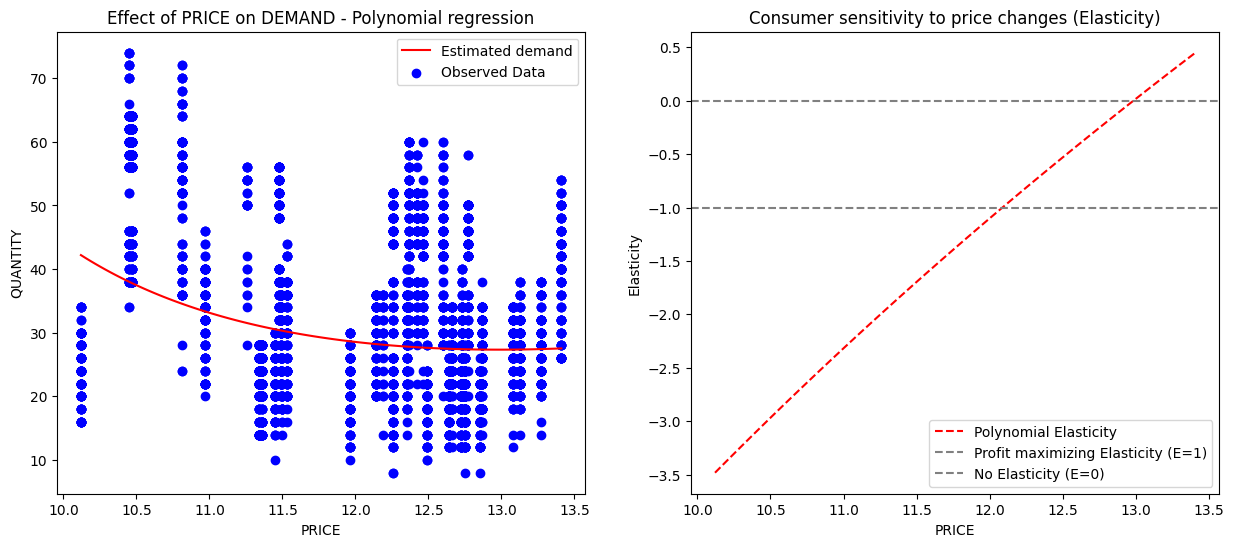

In [24]:

poly_model = smf.ols(formula='np.log(QUANTITY) ~ np.log(PRICE) + I(np.log(PRICE)**2) + IS_WEEKEND + np.log(AVERAGE_TEMPERATURE)', data=dft).fit()
logmodel = smf.ols(formula='np.log(QUANTITY) ~ PRICE', data=dft).fit()


# Because we took the log, we need to exponentiate the predictions to get the actual demand values
predict_df['poly_pred'] = np.exp(poly_model.predict(predict_df))
predict_df['linear_pred'] = np.exp(logmodel.predict({'PRICE': PRICE_RANGE}))

fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(predict_df['PRICE'], predict_df['poly_pred'], label='Estimated demand', color='red')
ax1.scatter(dft['PRICE'], dft['QUANTITY'],  label='Observed Data', color='blue')

coef = poly_model.params
beta_1 = coef['np.log(PRICE)']          # Main effect
beta_2 = coef['I(np.log(PRICE) ** 2)']  # Partial effect

# Calculate elasticity for each price in the range
# Point elasticity when your model is in levels (i.e., not log-transformed).
# Derivative of the demand function with respect to price, multiplied by the price over the demand
# elasticity = (demand'(price) * price) / demand(price)
elasticity = (beta_1 + 2 * beta_2 * np.log(PRICE_RANGE)) * PRICE_RANGE / predict_df['poly_pred']

elasticity_poly = beta_1 + 2 * beta_2 * np.log(PRICE_RANGE)
ax2.plot(PRICE_RANGE, elasticity_poly, label='Polynomial Elasticity', color='red', linestyle='--')
ax2.axhline(-1, color='gray', linestyle='--', label='Profit maximizing Elasticity (E=1)')
ax2.axhline(0, color='gray', linestyle='--', label='No Elasticity (E=0)')

# ax2.set_ylabel('Estimated elasticity')
ax1.set_title('Effect of PRICE on DEMAND - Polynomial regression')
ax2.set_title('Consumer sensitivity to price changes (Elasticity)') 
ax1.set_xlabel('PRICE') 
ax2.set_xlabel('PRICE')
ax1.set_ylabel('QUANTITY')
ax2.set_ylabel("Elasticity")
ax1.legend()
ax2.legend()
plt.show()

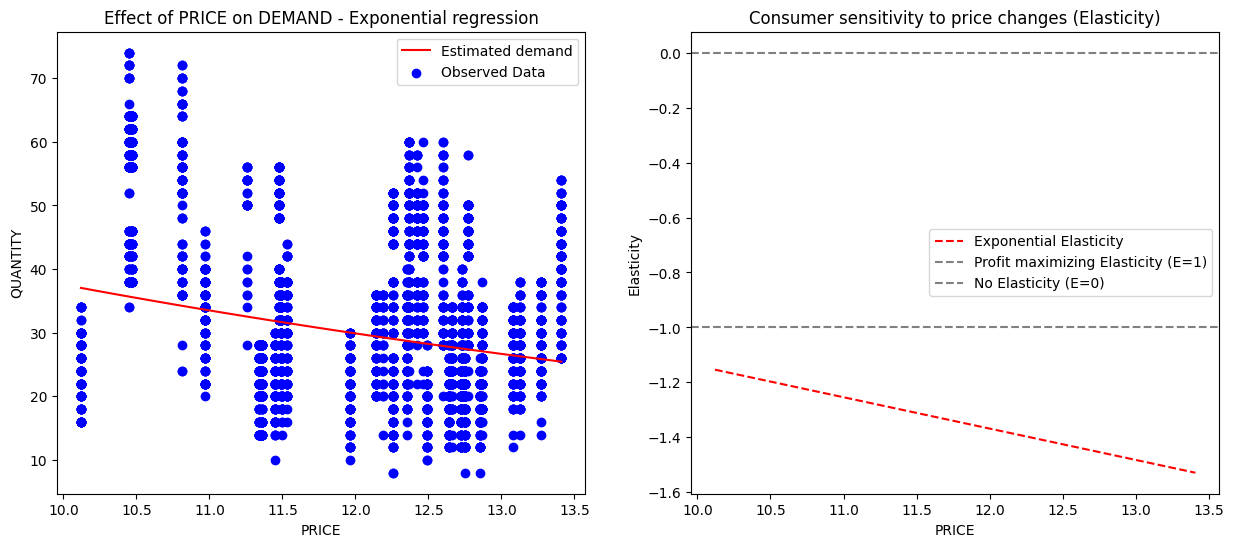

In [25]:
fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(predict_df['PRICE'], predict_df['linear_pred'], label='Estimated demand', color='red')
ax1.scatter(dft['PRICE'], dft['QUANTITY'],  label='Observed Data', color='blue')

elasticity_exp = logmodel.params['PRICE'] * PRICE_RANGE
ax2.plot(PRICE_RANGE, elasticity_exp, label='Exponential Elasticity', color='red', linestyle='--')

ax2.axhline(-1, color='gray', linestyle='--', label='Profit maximizing Elasticity (E=1)')
ax2.axhline(0, color='gray', linestyle='--', label='No Elasticity (E=0)')

# ax2.set_ylabel('Estimated elasticity')
ax1.set_title('Effect of PRICE on DEMAND - Exponential regression')
ax2.set_title('Consumer sensitivity to price changes (Elasticity)') 
ax1.set_xlabel('PRICE') 
ax2.set_xlabel('PRICE')
ax1.set_ylabel('QUANTITY')
ax2.set_ylabel("Elasticity")
ax1.legend()
ax2.legend()
plt.show()



In terms of performance, the polynomial regression seems to be a better fit of the data in terms of statistic measurements such as adj R^2 and AIC/BIC, but it has a curve that eventually becomes upward slopping, which is not the functional form we would expect from the relationship between price as quantities sold as we would expect the consumer to buy less when prices are higher.

In [26]:
print("Log model        BIC: ", round(logmodel.bic, 0), ", R^2: ", round(logmodel.rsquared_adj,2))
print("Polynomial model BIC: ", round(poly_model .bic, 0), ", R^2: ", round(poly_model .rsquared_adj,2))

Log model        BIC:  3802.0 , R^2:  0.06
Polynomial model BIC:  3169.0 , R^2:  0.2


More commonly, elasticity is modeled using a logit price response function because this transformation alings more closely with a demand curve that has diminishing marginal returns at the extremes.  Meaning consumers are more sensitive to price changes in the middle range, becoming more unresponsive in the extremes.  


# 6. Are consumers more price sensitive during the weekend?

In this section we introduce the topic of interactions, and how we can use them.  Interactions come in two flavors depending on whether we are dealing with a continous or a categorical variable.  For our model of the effect of PRICE on QUANTITY, these two types of variables have two different interpretation:

1)  For categorical variables like weekend vs non-weekend, an interaction measures of the effect is different for each type of day
2)  For continous variable, an interaction measures the amount of effect in addition to their individual combined effect, in other words, it measures the synergy between continous variables.  For example, if price has an effect of X1 and another variable has an effect of X2, an interactino would measure if the effect of X1 and X2 is more than X1+X2.

First, lets re-print the full model before adding the interaction for the sake of comparison

In [27]:
print(full_model.summary().tables[1])


                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       7.1391      0.211     33.896      0.000       6.726       7.552
np.log(PRICE)                  -1.3630      0.078    -17.390      0.000      -1.517      -1.209
IS_WEEKEND                     -0.3131      0.013    -25.009      0.000      -0.338      -0.289
np.log(AVERAGE_TEMPERATURE)    -0.0677      0.014     -4.898      0.000      -0.095      -0.041


After adding the interaction as shown below. (labeled : "np.log(PRICE):IS_WEEKEND"  ), we can see that consumers are more price sensitive during the weekend, and that difference is statistically significant.  In other words, consumers respond differently to price increases during weekdays than on weekends.

In [28]:
interaction_model = smf.ols(formula='np.log(QUANTITY) ~ np.log(PRICE) + np.log(PRICE):IS_WEEKEND + np.log(AVERAGE_TEMPERATURE)', data=dft).fit()
print(interaction_model.summary().tables[1])

                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       7.1958      0.210     34.233      0.000       6.784       7.608
np.log(PRICE)                  -1.3887      0.078    -17.727      0.000      -1.542      -1.235
np.log(PRICE):IS_WEEKEND       -0.1248      0.005    -24.976      0.000      -0.135      -0.115
np.log(AVERAGE_TEMPERATURE)    -0.0664      0.014     -4.830      0.000      -0.093      -0.039


Technical notes: To do hypothesis testing such as significance, additional tests are needed to test if our model meets the assumptions of linear regression, namely heteroskadascity and normality of residuals.

Second technical note: When including both main and partial effect for WEEKEND, our model had structural multicolinearity, so I just dropped the main effect and left only the interaction though centering would have been a better solution.

# 7. Are consumers becoming more or less price sensitive over time?
Coefficient stability

We also know that price sensitivity or elasticity is not constant but changes over time.  There are multiple ways to measure this change such as using ARIMA, or linear regression with a time step interaction. In this section, we'll recursively build a simple regression across time and graph the resuls. (See below graph)

In [29]:

model = smf.ols(formula='np.log(QUANTITY) ~ np.log(PRICE) + IS_WEEKEND + np.log(AVERAGE_TEMPERATURE)', data=dft).fit()

rec_exog = pd.DataFrame(model.model.exog, columns=model.model.exog_names)
rec_endog = pd.DataFrame(model.model.endog, columns= [model.model.endog_names])

mod = sm.RecursiveLS(rec_endog, rec_exog)
res = mod.fit()
# print(res.summary())

time_points = dft.index
coefs = res.recursive_coefficients['filtered'][1, :]
covered = time_points>(pd.to_datetime('2013-10-01'))

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=time_points[covered], 
    y=coefs[covered],
    mode='lines',
    name=f'Coefficient'
))

fig.update_layout(
    title="Price elasticity over time",
    xaxis_title="Time",
    yaxis_title="Coefficient Value",
    template="plotly_dark",
    yaxis=dict(
        range=[-2, -1]  # Set the Y-axis range
    )

)

fig.show()


From our graph, we can see that consumers became less sensitive to price increases (lower elasticity) for the first year and a half, and then started trending to higher sensitivity again, but all 3 years show prices to be elastic (higher than -1) range meaning that prices should have been lower in order to maximize revenue.

# 8. Modeling effects that we cannot measure
Unobserved heterogeneity

Suppose that advertising was shown some days of the week, but we have no records of which days those are.  Can we still measure the effect of advertisement on sales? The answer is yes.  

If we assume that our model so far includes all relevant predictors, then we can say that our data is divided into two groups, group one that saw the advertisment, and group two that did NOT see it.  Because we assume that our model already accounts for all other predictors, then the only difference between the two groups is the advertistement.

From the underlying distribution we see some evidence that we may have a binomial distribution, providing some support to using a model that accounts for this difference



<Axes: xlabel='QUANTITY', ylabel='Density'>

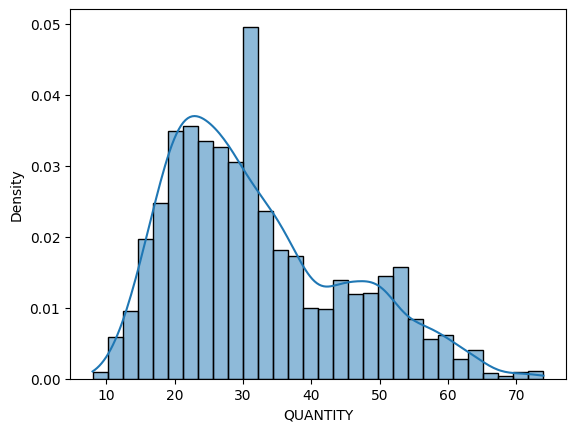

In [30]:
sns.histplot(data=dft, x="QUANTITY", bins=30, kde=True, stat='density')


#### Maximum likelihood estimation

To measure it we will use a Gaussian mixture model fitted using Maximum Likelihood Estimation (MLE). This algorithm is prone to getting stuck in local minima, so I restarted a few times using different initialization parameters eventually settling for the code below.  For simplicity we are using scipy optimize.



In [31]:
# GMM with one parameter
def gmm_one_parma(beta1_init, beta2_init, MLE_X_matrix, y):
    
    num_params = MLE_X_matrix.shape[1]
    num_params2 = num_params * 2

    # Define bounds.  These go in the same order as the initial parameters matrix.  Provided as a list.
    bounds = [(None, None)] * (2 * num_params)  # Beta coefficients for both groups
    bounds += [(1e-3, None)] * 2                # Standard deviations should be positive
    bounds += [(1e-2, 1 - 1e-2)]                # Mixing probability should be between 0.01 and 0.99


    def log_likelihood(params):
        beta1, beta2 = params[:num_params], params[num_params:num_params2]
        sigma1, sigma2, p = params[num_params2], params[num_params2+1], params[num_params2+2]
        
        # Compute probability densities for two normal distributions
        prob1 = norm.pdf(y, loc=MLE_X_matrix @ beta1, scale=sigma1)
        prob2 = norm.pdf(y, loc=MLE_X_matrix @ beta2, scale=sigma2)

        mixture_prob = p * prob1 + (1 - p) * prob2
        mixture_prob = np.clip(mixture_prob, 1e-10, None)  # Prevent log(0)

        return -np.sum(np.log(mixture_prob))  # Negative log-likelihood

    # May need to be modified if extra features are added to the matrix.
    # initial parameters passed as an array of shape (num_params + 3,)
    initial_params = np.array([
        beta1_init,  # Beta1
        beta2_init,  # Beta2
        np.std(y) / 2,  # Sigma1
        np.std(y) / 2,  # Sigma2
        0.5  # Mixing probability (50/50 split)
    ])


    result = opt.minimize(log_likelihood, initial_params, method='L-BFGS-B', bounds=bounds)

    beta1_hat, beta2_hat = result.x[:num_params], result.x[num_params:num_params2]
    sigma1_hat, sigma2_hat = result.x[num_params2], result.x[num_params2+1]   
    p_hat = result.x[num_params2+2]


    print("Estimated Parameters:")
    print(f"Beta1: {beta1_hat}")
    print(f"Sigma1: {sigma1_hat}")
    print(f"Beta2: {beta2_hat}")
    print(f"Sigma2: {sigma2_hat}")
    print(f"Mixing Probability: {p_hat}")
    print(f"Negative Log-likelihood: {result.fun}")

    return beta1_hat, beta2_hat, sigma1_hat, sigma2_hat, p_hat, result

In [32]:
y = dft['QUANTITY'].values
MLE_X_matrix = dft[['PRICE']].values

# Initial values for the optimization
beta1_init = np.mean(y) / np.mean(MLE_X_matrix)  # Beta1
beta2_init = np.mean(y) / np.mean(MLE_X_matrix)  # Beta2
# beta1_init = np.log(dft['PRICE'].mean())/np.log(22)
# beta2_init = np.log(dft['PRICE'].mean())/np.log(50)


beta1_hat, beta2_hat, sigma1_hat, sigma2_hat, p_hat, results= gmm_one_parma(beta1_init, beta2_init, MLE_X_matrix, y)

Estimated Parameters:
Beta1: [2.60537036]
Sigma1: 13.59678736209851
Beta2: [2.60537036]
Sigma2: 13.59678736209851
Mixing Probability: 0.5
Negative Log-likelihood: 16360.855559055064


Initialization parameters:

$$
Since
\\[10pt]
log(y) = \beta_1 log(x)
\\[10pt]
then  \quad \beta_1 = \frac{\log (x)}{\log (y)}
$$


I first initialized the model using average QUANTITY/ average PRICE

From the previous results, we can see that the model estimated identical normal distributions for both groups when using a simple mean as the parameter initialization.  The mixing probability of .5 indicates that each day has a 50/50 chance of being a day when advertisement was shown, which is uninformative and unlikely to be the case if advertisement had indeed an effect.  Additionally, the coefficients are identical.

Below we try a different initialization and seee what we get

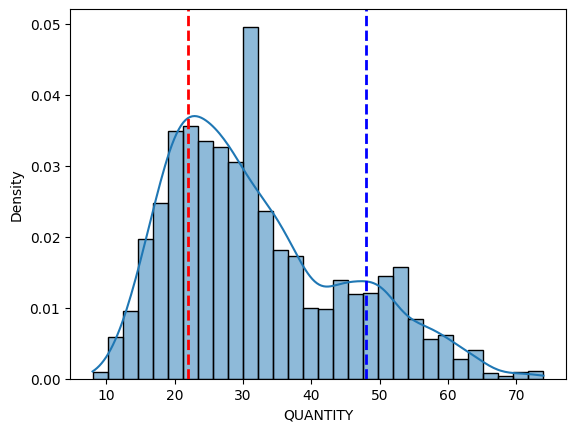

In [33]:
sns.histplot(data=dft, x="QUANTITY", bins=30, kde=True, stat='density')

plt.axvline(x=22, color='red', linestyle='--', linewidth=2)
plt.axvline(x=48, color='blue', linestyle='--', linewidth=2)

plt.show()


Average price for our dataset $12.
$$\\$$
22 and 48 is where you can see an increase in the histogram from the last chart, so I tried these two:
$$
\frac{\log(12)}{\log(22)} \text{ and } \frac{\log(12)}{\log(48)}.
$$

In [34]:
beta1_init = np.log(dft['PRICE'].mean())/np.log(22)
beta2_init = np.log(dft['PRICE'].mean())/np.log(48)


beta1_hat, beta2_hat, sigma1_hat, sigma2_hat, p_hat, results= gmm_one_parma(beta1_init, beta2_init, MLE_X_matrix, y)

Estimated Parameters:
Beta1: [3.41332872]
Sigma1: 13.428306682766095
Beta2: [1.92571113]
Sigma2: 5.959884981820984
Mixing Probability: 0.4730124120836439
Negative Log-likelihood: 15943.364687143796


Here we can see our model did sucessfuly split into two different groups, and the negative log likelihood is larger than our previous model indicating that two group model does indeed represent the sample better than a single group. 


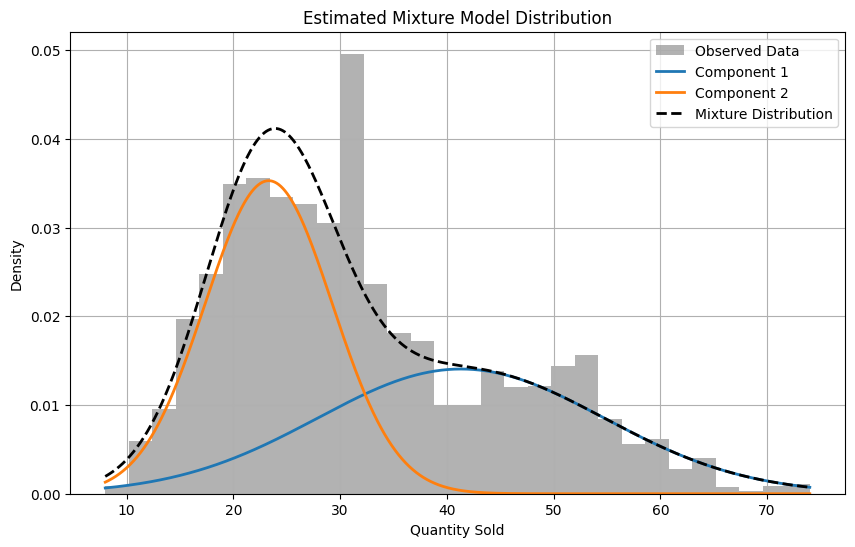

In [35]:

mean1 = np.mean(MLE_X_matrix @ beta1_hat)
mean2 = np.mean(MLE_X_matrix @ beta2_hat)

x_range = np.linspace(min(y), max(y), 1000)

# Compute the probability densities for both components
pdf1 = norm.pdf(x_range, loc=mean1, scale=sigma1_hat)
pdf2 = norm.pdf(x_range, loc=mean2, scale=sigma2_hat)

plt.figure(figsize=(10, 6))
plt.hist(y, bins=30, density=True, alpha=0.6, color='gray', label="Observed Data")

# Plot estimated mixture components
plt.plot(x_range, p_hat * pdf1, label="Component 1", linewidth=2)
plt.plot(x_range, (1 - p_hat) * pdf2, label="Component 2", linewidth=2)

mixture_pdf = p_hat * pdf1 + (1 - p_hat) * pdf2
plt.plot(x_range, mixture_pdf, label="Mixture Distribution", linestyle="dashed", linewidth=2, color="black")

plt.xlabel("Quantity Sold")
plt.ylabel("Density")
plt.title("Estimated Mixture Model Distribution")
plt.legend()
plt.grid()

# Show plot
plt.show()


#### Now we can answer some questions:

For any given price, and day of the week, including the advertisement increases sales by an average of 18.  Calculated as:

In [36]:
print(mean1-mean2)

18.007195222153218


We can also compute what is the probability that the advertising was run a particular day given the price and quantity.  For example, if the price was $13.41 and 42 units were sold, what is the probability that adversitement was ran that day?

This can be calcuated using Bayes formula:

$$
P(H_1 \mid E) = \frac{P(H_1) P(E \mid H_1)}{P(H_1) P(E \mid H_1) + P(H_2) P(E \mid H_2)}
$$

$$
P(\text{grp1} \mid E) = \frac{P(\text{grp1}) * \text{Likelihood1} }{P(\text{grp1}) * \text{Likelihood1} + P(\text{grp2}) * \text{Likelihood2}}
$$


where likelihood represents the probability of seeing y quantity sold given the price x

In [37]:
# Compute the probability that each data point belongs to each component

# Gaussian likelihoods for each component
likelihood1 = norm.pdf(y, (beta1_hat * MLE_X_matrix).squeeze(), sigma1_hat)
likelihood2 = norm.pdf(y, (beta2_hat * MLE_X_matrix).squeeze(), sigma2_hat)

# Posterior probabilities (Bayes' theorem) of belonging to each group
num = (p_hat * likelihood1)                             # Prior probability * Likelihood
den = (p_hat * likelihood1 + (1 - p_hat) * likelihood2) # Total probability
prob1 = num / den
prob2 = 1 - prob1

prob_df = pd.DataFrame({
    "PRICE": MLE_X_matrix.flatten(),
    "QUANTITY": y,
    "Probability_Component_1": prob1,
    "Probability_Component_2": prob2
}, index = dft.index)

prob_df.sort_values(by='PRICE', ascending=False).head(2)


,PRICE,QUANTITY,Probability_Component_1,Probability_Component_2
CALENDAR_DATE,,,,
2012-12-27,13.41,42,0.94,0.06
2013-03-09,13.41,34,0.41,0.59


In the above results for December 27, there is a 90% probability that the advertising was shown given that sales were 42 with a price of $13.4 whereas for March 3, there is only a 40% probability that it was shown

# Appendix - 

### Poisson model

Since our data is actually count, it would be more appropiate to use a poisson distribution rather than a gaussian one.  However, looks like the Poisson assumption that the mean=variance is violated (see below), so we should not use it.  In our case the variance is greater than the mean, which suggest overdispersion.  To deal with this overdispersion, we can use a poisson-gamma (negative binomial) distribution which has an additional parameter to account for the non-constant variance. 

Instead of assuming a fixed $\lambda$, we assume it follows a Gamma distribution:


$$
\lambda \sim \text{Gamma}(\alpha, \beta)
$$

The Gamma distribution is:

$$
P(\lambda) = \frac{\beta^\alpha}{\Gamma(\alpha)} \lambda^{\alpha - 1} e^{-\beta \lambda}
$$

Here, $\alpha$ is the shape parameter, and $\beta$ is the rate parameter.


In [38]:
mean_y = np.mean(y)
variance_y = np.var(y)

print(f"Mean: {mean_y}")
print(f"Variance: {variance_y}")

Mean: 31.949766067471067
Variance: 163.62810940107462


Not implemented

### Logit price response function

For this section, we'll move away from linear regression and use logit function.  Instead of estimating quantities, we are going to estimate the odds a consumer chooses to purchase our product given all factors including competition. Our target value becomes the probability of purchasing, which for our purpose we will model as the market share of our product.  An advantage of this approach is that elasticity takes the functional form of a sigmoid curve as seen below

$$
P(y = 1 | x) = \frac{e^{\beta_0 + \beta_1 x}}{1 + e^{\beta_0 + \beta_1 x}}
$$


where:

- P(y = 1 | x)  = probability of purchase at price ,
- $\beta_0$  intercept (baseline preference for the product),
- $\beta_1$  price elasticity (effect of price, on likelihood of purchasing the product),
- x = price of the product.

The elasticity would then be given by:

$$
\varepsilon = \frac{dQ}{dP} \times \frac{P}{Q}
$$

Because my (fake) data did not follow the shape of this transformation very well, I have created a different dataset to illustrate the point of diminishing marginal utility at both extremes of the price range



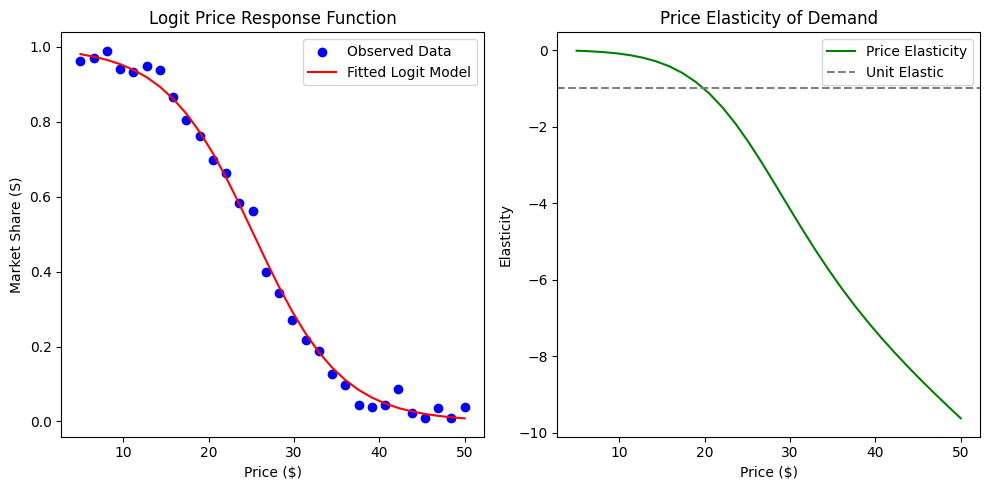

Estimated β0: 4.906, Estimated β1: -0.194


In [39]:
prices = np.linspace(5, 50, 30)  # Prices from $5 to $50
beta_0, beta_1 = 5, -0.2         # True coefficients
Q_max = 1000                     # Maximum quantity sold

# Generate quantity sold using a logit function + noise
quantities = Q_max * (np.exp(beta_0 + beta_1 * prices) / (1 + np.exp(beta_0 + beta_1 * prices)))
quantities += np.random.normal(0, 30, size=len(quantities)) 

market_share = np.clip(quantities / Q_max, 0.01, 0.99)
XX = sm.add_constant(prices)

glm_model = sm.GLM(market_share, XX, family=sm.families.Binomial(link=sm.families.links.logit())).fit()
market_share_pred = glm_model.predict(XX)

b0_hat, b1_hat = glm_model.params

elasticities = b1_hat * prices * (1 - market_share_pred)

# Plot results
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(prices, market_share, label="Observed Data", color="blue")
plt.plot(prices, market_share_pred, label="Fitted Logit Model", color="red")
plt.xlabel("Price ($)")
plt.ylabel("Market Share (S)")
plt.title("Logit Price Response Function")
plt.legend()

plt.subplot(1,2,2)
plt.plot(prices, elasticities, label="Price Elasticity", color="green")
plt.axhline(y=-1, color="gray", linestyle="--", label="Unit Elastic")
plt.xlabel("Price ($)")
plt.ylabel("Elasticity")
plt.title("Price Elasticity of Demand")
plt.legend()

plt.tight_layout()
plt.show()

# Print estimated parameters
print(f"Estimated β0: {b0_hat:.3f}, Estimated β1: {b1_hat:.3f}")
